# The DataLab Challenge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='sans-serif', size=200)
import pandas as pd
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neural_network import MLPRegressor
from sklearn import cross_validation, tree, linear_model
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data import, clean-up and sanity checks

In [3]:
# Setup the seasons
years = ["07","08","09","10","11","12","13","14","15","16","17","18"]
seasons = [year1+year2 for year1, year2 in zip(years, years[1:]+[years[0]])][:-1] # remove last element

In [4]:
# Grab the data
dataHome = pd.concat([pd.read_csv("http://www.football-data.co.uk/mmz4281/"+season+"/E0.csv", usecols = ["FTHG", "WHH", "HST"], skip_blank_lines=True) for season in seasons])
dataAway = pd.concat([pd.read_csv("http://www.football-data.co.uk/mmz4281/"+season+"/E0.csv", usecols = ["FTAG", "WHA", "AST"], skip_blank_lines=True) for season in seasons])

In [5]:
# Merge the home and away datasets into a single dataframe, rename columns to unify descriptions
dataHome.rename(columns = {"FTHG":"FTG", "WHH":"WH", "HST":"ST"}, inplace = True)
dataAway.rename(columns = {"FTAG":"FTG", "WHA":"WH", "AST":"ST"}, inplace = True)
dataHome['HomeOrAway'] = 1
dataAway['HomeOrAway'] = 0
df = pd.concat([dataHome,dataAway])

In [6]:
# Some clean-up as some WH odds are NaN
df = df.dropna(axis=0,how='any') # WH odds
df.isnull().sum()

FTG           0
ST            0
WH            0
HomeOrAway    0
dtype: int64

In [24]:
# Summary information
print("Length of dataset: %d" % len(df))
print("Number of columns: %d" % len(df.columns))
print("Data types", df.dtypes.unique())
print(df.describe())

Length of dataset: 8034
Number of columns: 4
('Data types', array([dtype('float64'), dtype('int64')], dtype=object))
               FTG           ST           WH   HomeOrAway
count  8034.000000  8034.000000  8034.000000  8034.000000
mean      1.356983     5.679487     3.729556     0.500000
std       1.255000     3.324510     3.099440     0.500031
min       0.000000     0.000000     1.070000     0.000000
25%       0.000000     3.000000     1.910000     0.000000
50%       1.000000     5.000000     2.700000     0.500000
75%       2.000000     8.000000     4.200000     1.000000
max       9.000000    24.000000    26.000000     1.000000


## Explore correlations

In [21]:
# Look for some correlations between the variables
features = ["HomeOrAway","FTG", "WH"]
target = "ST"

correlations = {}
for f in features:
    temp = df[[f,target]]
    x1 = temp[f].values
    x2 = temp[target].values
    print(f + ' vs ' + target + ":\t %10.3g" % pearsonr(x1,x2)[0])

HomeOrAway vs ST:	      0.204
FTG vs ST:	      0.442
WH vs ST:	     -0.333


From the above we see that there are is a positive correlation between the shots on target (ST) with the full-time goals (FTG) and a negative correlation with the William Hill (WH) odds. There is a smaller correlation between the shots on target and whether a team is home or away, favouring the home team. We can see this in another way using the plots below.

Text(0,0.5,u'Shots on target')

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


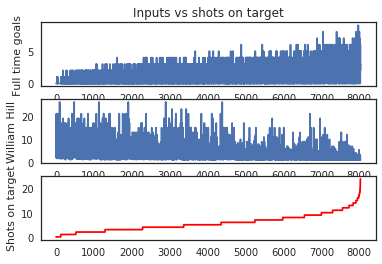

In [10]:
# Make some plots
y = df.loc[:,["FTG","WH",target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Inputs vs shots on target')
plt.ylabel('Full time goals')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('William Hill')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],"r")
plt.ylabel("Shots on target")

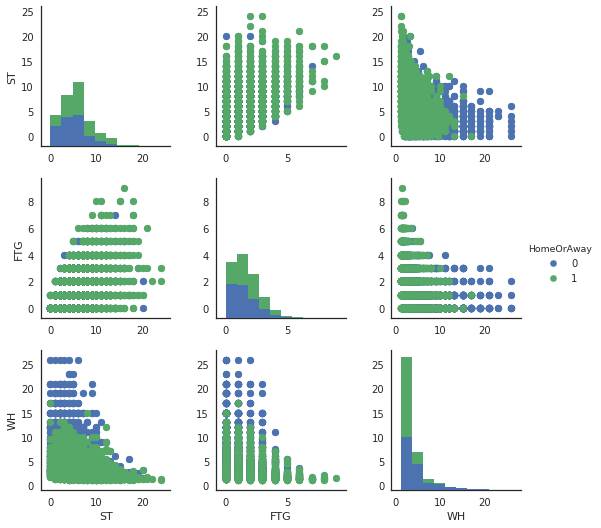

In [11]:
# Make some plots to show the correlations between variables
g = sns.pairplot(df, vars = ["ST", "FTG", "WH"],hue="HomeOrAway")
g = g.map_upper(plt.scatter)
g = g.map_lower(plt.scatter)
g = g.map_diag(plt.hist)

## Regression

Now train the regression algorithm. There are various options here, but just keep it simple. Use the train_test_split to avoid overtraining. Could also use K-folds.

In [26]:
# Scikit-learn MLP
clf = MLPRegressor(solver='adam', max_iter=400, activation='relu', learning_rate_init=0.001)
#clf = linear_model.LinearRegression()

X = df[["HomeOrAway", "FTG", "WH"]].values
y = df[["ST"]].values

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

clf.fit(X_train, y_train)
print("Score: %f"% clf.score(X_test,y_test))
predictions = clf.predict(X_test)
print("Explained variance score (1 is optimal): %f" % explained_variance_score(predictions,y_test))

Score: 0.242928
Explained variance score (1 is optimal): -1.922488


From the above score we can tell that the performance is not very good. Would be better to use additional features of the dataset to improve the prediction.

## Estimates about shots on target

In [30]:
# Now answer the questions posed
# a. Home team, 1 goal, WHH of 2.0. 
print("a. Predicted number of shots on target = %d" % clf.predict([[1, 1, 2.0]])[0])
# b. Home team, 3 goal, WHH of 2.0. 
print("b. Predicted number of shots on target = %d" % clf.predict([[1, 3, 2.0]])[0])
# c. Away team, 1 goal, WHH of 2.0. 
print("c. Predicted number of shots on target = %d" % clf.predict([[0, 1, 2.0]])[0])

a. Predicted number of shots on target = 6
b. Predicted number of shots on target = 7
c. Predicted number of shots on target = 5


## Summary

Using only three pieces of information (full-time goals, WH odds and HomeOrAway) to train a simple regression does not lead to particularly good performance for the shots on target. The strongest correlations between these variables and the shots on target comes from the full-time goals information. As a next step it would be better to try using additional information that is available in the dataset. 